<a href="https://colab.research.google.com/github/Ukbang/Build_with_AI_250405/blob/main/1_DataAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain langgraph langchain-google-genai langchain-core langchain-community langchain-experimental koreanize-matplotlib

In [ ]:
import pandas as pd
import re
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Annotated, Literal, Tuple
from typing_extensions import TypedDict
from langchain.schema import AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
import base64
import io
import os
import warnings

warnings.filterwarnings("ignore")

In [ ]:
google_api_key = "" # @param {"type":"string"}

In [ ]:
# 환경변수에 Goolge API Key 등록

os.environ["google_api_key"] = google_api_key
os.environ["GOOGLE_API_KEY"] = google_api_key

In [ ]:
# 데이터프레임 불러오기

url = "https://raw.githubusercontent.com/Ukbang/Build_with_AI_250405/main/data/titanic.csv"
df = pd.read_csv(url)

In [ ]:
# 데이터프레임 정보 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# 그래프 상태 정의

class State(TypedDict):
    messages : Annotated[list, add_messages] # History
    code : Annotated[str, "Python code"]
    code_result : Annotated[str, "Python code Result"]

In [ ]:
# LLM 로드
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                             temperature=0.,
                             convert_system_message_to_human=True,
                             )

# 파이썬 코드 실행 도구 정의
tool = PythonAstREPLTool(name="python_repl_ast",
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                         locals={"df":df})

In [ ]:
# 데이터셋 제목, 요약 생성 함수

def create_title_summary(df:pd.DataFrame) -> Tuple[str, str]:


    # 데이터셋이 너무 클 시 1000개의 샘플만 제공
    df_sampled = df.sample(n=3000) if len(df) > 3000 else df

    prompt = PromptTemplate.from_template("""
            당신은 요약 전문가입니다.

            데이터셋 : {df}

            데이터셋의 정보를 보고 제목과 요약을 만들어냅니다.
            제목은 이 데이터셋을 가장 잘 표현할 수 있는 제목으로 결정하여야합니다.

            참고할 정보는 아래와 같습니다.
            """
            f"""

            1. 제목:
            2. 요약:

            """
            )

    chain = prompt | llm

    # chain.invoke는 AI Message객체를 반환함. 그 중 str 형태인 content만 추출
    result = chain.invoke({"df":df_sampled})
    print(result)

    title = "Untitled"
    summary = "No Summary"

    # 요약 양식에 맞지 않는 답변을 할 시 "Untitle"과 "No Summary"로 설정하도록 예외처리
    try:
        lines = result.content.split("\n\n")
        title = lines[0].replace("## 제목:", "").strip()
        summary = "\n".join(lines[1:]).replace("## 요약:", "").strip()
    except:
        pass

    print("===== 제목, 요약 생성 완료 =====")

    return title, summary

In [ ]:
# 제목, 요약 생성

title, summary = create_title_summary(df)

content='## 제목: 타이타닉호 승객 생존 예측 분석 데이터셋\n\n## 요약:\n\n본 데이터셋은 타이타닉호에 탑승했던 승객 891명의 정보를 담고 있으며, 각 승객의 생존 여부(Survived)를 예측하기 위한 다양한 변수들을 포함하고 있습니다. 주요 변수로는 승객 ID(PassengerId), 객실 등급(Pclass), 성별(Sex), 나이(Age), 동반한 형제자매/배우자 수(SibSp), 동반한 부모/자녀 수(Parch), 티켓 번호(Ticket), 요금(Fare), 객실 번호(Cabin), 승선 항구(Embarked) 등이 있습니다. 이 데이터셋은 머신러닝 모델을 활용하여 타이타닉호 침몰 사고에서 생존에 영향을 미친 요인을 분석하고, 생존 예측 모델을 개발하는 데 활용될 수 있습니다.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-413b6239-f8ea-4468-8a98-fbdaaa3d48fe-0' usage_metadata={'input_tokens': 772, 'output_tokens': 227, 'total_tokens': 999, 'input_token_details': {'cache_read': 0}}
===== 제목, 요약 생성 완료 =====


In [ ]:
print("제목 : ", title)
print("요약 : ", summary)

제목 :  타이타닉호 승객 생존 예측 분석 데이터셋
요약 :  본 데이터셋은 타이타닉호에 탑승했던 승객 891명의 정보를 담고 있으며, 각 승객의 생존 여부(Survived)를 예측하기 위한 다양한 변수들을 포함하고 있습니다. 주요 변수로는 승객 ID(PassengerId), 객실 등급(Pclass), 성별(Sex), 나이(Age), 동반한 형제자매/배우자 수(SibSp), 동반한 부모/자녀 수(Parch), 티켓 번호(Ticket), 요금(Fare), 객실 번호(Cabin), 승선 항구(Embarked) 등이 있습니다. 이 데이터셋은 머신러닝 모델을 활용하여 타이타닉호 침몰 사고에서 생존에 영향을 미친 요인을 분석하고, 생존 예측 모델을 개발하는 데 활용될 수 있습니다.


In [ ]:
# LLM에게 도구 할당

llm_with_tools = llm.bind_tools([tool])

In [ ]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [ ]:
# LLM의 응답을 HistoryChecker 클래스 구조에 맞춰 파싱하도록 설정

history_checker = llm.with_structured_output(HistoryChecker)

In [ ]:
# 히스토리 기반 답변 분기를 위한 함수 설정

def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.

                대화 기록 : {history}

                질문 : {query}

                """)

    chain = prompt | history_checker

    result = chain.invoke({"history":state["messages"][:-1],
                            "query":state["messages"][-1]})

    return result.yes_no

In [ ]:
# 식별을 위한 노드

def history_node(state:State):

    return

In [ ]:
# 도구 사용 여부 결정 노드

def select(state:State):
    prompt = PromptTemplate.from_template("""
            당신은 데이터 분석가입니다.
            당신은 데이터프레임인 df를 활용할 수 있습니다.
            당신이 활용 가능한 데이터프레임의 예시는 아래와 같습니다.
            아래의 예시는 `print(df.head())`의 실행결과입니다
            활용 가능한 데이터프레임을 갖고 있으니 데이터프레임을 새로 생성할 필요 없습니다.
            코드에 한글이 필요하다면 `import koreanize_matplotlib`을 사용하세요.

            당신은 'python_repl_ast'라는 파이썬 코드 실행 도구을 가지고 있습니다.
            tool_calls를 할 때에는 'python_repl_ast'만을 사용하세요. 그 외의 다른 도구는 사용하면 안됩니다.
            이를 참고하여 질문에 대한 코드를 생성합니다.

            df : {df}

            title : {title}
            summary : {summary}

            query : {query}
            """
            )

    chain = prompt | llm_with_tools

    result = chain.invoke({"df":df.head(),
                           "title":title,
                            "summary":summary,
                            "query":state["messages"][-1].content})

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = result.tool_calls

        # 코드 추출
        code = tool_calls[0]["args"]["query"]
        return {"code": code}
    else:
        # 도구 사용을 안한다면 코드는 공백으로 설정
        return {"code":""}

In [ ]:
def code_executor(state:State):


    try:
        # 코드 실행 결과인 이미지 추출
        if "plt" in state["code"] or "sns" in state["code"]:
            save_fig = """
import io
import base64

buf = io.BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)

encoded = base64.b64encode(buf.read()).decode("utf-8")

print(encoded)
"""

            execute_code = state["code"] + save_fig

            result = tool.invoke(execute_code)

            return {"code_result":result}
        # 시각화가 아닌 경우 코드만 실행
        else:
            result = tool.invoke(state["code"])
            return {"code_result":result}
    except:
        return {"code_result": ""}

In [ ]:
# 코드에 의한 답변 노드

def code_response(state:State):
    prompt = ChatPromptTemplate.from_messages([
        ("system", """코드 : {code} \n
                    결과 : {code_result}
        당신은 주어진 코드와 코드 결과를 바탕으로 질의에 대해 답변합니다.
        절대 코드에 대해 설명하지마세요.
        독자는 프로그래머가 아닙니다.
        항상 출력되는 값을 기준으로 설명합니다.
        숫자가 매우 중요합니다. 숫자에 대한 정보를 잊지 마세요.
        데이터 분석과 관련된 코드가 입력된다면 항상 인사이트를 포함하세요. """),
        ("human", '{query}')
    ])

    chain = prompt | llm

    result = chain.invoke({"code":state["code"],
                        "code_result":state["code_result"],
                        "query":state["messages"][-1]})

    return {"answer": result.content,
            "messages": result}

In [ ]:
# 기억 및 일반 응답 노드

def response(state:State):
    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.

                대화 기록 : {history}

                질문 : {query}

                """)

    chain = prompt | llm

    result = chain.invoke({"history":state["messages"][:-1],
                           "query":state["messages"][-1]})

    return {"messages":result}

In [ ]:
# 그래프 정의

graph_builder = StateGraph(State)

In [ ]:
# 노드 및 엣지 정의

graph_builder.add_node("history_node", history_node)
graph_builder.add_node("select", select)
graph_builder.add_node("code_executor", code_executor)
graph_builder.add_node("code_response", code_response)
graph_builder.add_node("response", response)


graph_builder.add_edge(START, "history_node")
graph_builder.add_conditional_edges("history_node",
                                    history_check,
                                    {
                                    "no":"select",
                                     "yes":"response"
                                     }
                                     )
graph_builder.add_edge("select", "code_executor")
graph_builder.add_edge("code_executor", "code_response")
graph_builder.add_edge("code_response", END)
graph_builder.add_edge("response", END);

In [ ]:
# 메모리 설정 및 그래프 컴파일

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

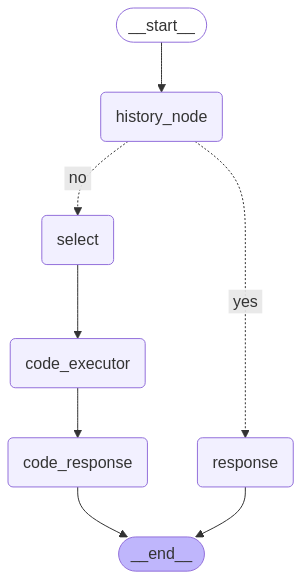

In [ ]:
# 그래프 시각화
# 가끔 "ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)"라는 에러가 발생
# 시간 초과로 그래프 생성에 실패했다는 메시지일뿐 기능과는 관계없으니 진행해도 괜찮습니다.

graph

In [ ]:
# 사용할 설정값 정의

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1050"})

In [ ]:
# 출력 함수 정의
# mode = "values" : 상태의 키, 값의 형태로 반환
# mode = "updates" : 업데이트되는 값만 반환

def streaming(query, config, mode="values"):

    result = graph.stream({"messages":("user", query)}, config=config, stream_mode=mode)

    if mode == "values":
        for step in result:
            for k, v in step.items():
                if k == "messages":
                    v[-1].pretty_print()
                    print("\n\n")
    elif mode == "updates":
        for step in result:
            for k,v in step.items():
                print(f"\n\n=== {k} ===\n\n")
                print(v)

    return

================================ Human Message =================================

생존자 비율 시각화하고 인사이트 제공해줘



================================ Human Message =================================

생존자 비율 시각화하고 인사이트 제공해줘





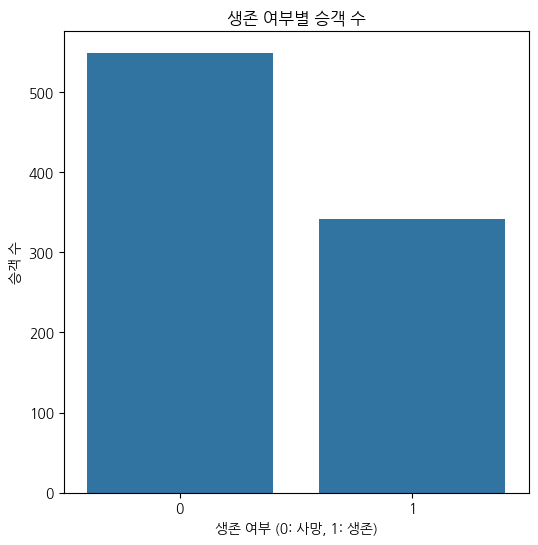

사망 비율: 0.62
생존 비율: 0.38
================================ Human Message =================================

생존자 비율 시각화하고 인사이트 제공해줘



================================== Ai Message ==================================

제공된 코드는 승객의 생존 여부에 따른 수를 시각화하고, 생존 및 사망 비율을 계산하여 출력합니다.

**시각화 결과**

*   **생존 여부별 승객 수**: 그래프는 생존하지 못한 승객보다 생존한 승객이 더 적음을 보여줍니다.

**생존/사망 비율**

*   **사망 비율**: 0.62 (62%)
*   **생존 비율**: 0.38 (38%)

**인사이트**

타이타닉호 승객 데이터에 따르면, 전체 승객 중 약 62%가 사망했고 38%만이 생존했습니다.





<Figure size 640x480 with 0 Axes>

In [ ]:
streaming("생존자 비율 시각화하고 인사이트 제공해줘", config)

In [ ]:
streaming("아까 내가 질문했던 내용 다시 알려줘", config)

================================ Human Message =================================

아까 내가 질문했던 내용 다시 알려줘



================================== Ai Message ==================================

이전 질문은 "생존자 비율 시각화하고 인사이트 제공해줘" 였습니다.





In [ ]:
streaming("아까 물어봤던 숫자들 다 더하면 몇인지 알려줘", config)

================================ Human Message =================================

아까 물어봤던 숫자들 다 더하면 몇인지 알려줘



================================== Ai Message ==================================

이전 대화에서 언급된 숫자는 다음과 같습니다.

*   사망 비율: 0.62
*   생존 비율: 0.38
*   사망자 비율: 62
*   생존자 비율: 38

이 숫자들을 모두 더하면 0.62 + 0.38 + 62 + 38 = 101 입니다.





In [ ]:
# 올림픽 데이터 로드 및 도구 재정의

url = "https://raw.githubusercontent.com/Ukbang/Build_with_AI_250405/main/data/athlete_events.csv"
df = pd.read_csv(url)

tool = PythonAstREPLTool(name="python_repl_ast",
                        description="A Python shell. Use this to execute python commands. \
                                    Input should be a valid python command. When using this tool, \
                                    sometimes output is abbreviated - make sure it does not look abbreviated before using it in your answer.",
                        locals={"df":df})


# 제목, 요약 생성
title, summary = create_title_summary(df)

content='## 제목: 올림픽 참가 선수 데이터 분석: 신체 정보, 참가 종목, 메달 획득 현황\n\n## 요약:\n\n본 데이터셋은 올림픽에 참가한 선수들의 개인 정보(ID, 이름, 성별, 나이, 키, 몸무게), 소속 국가(Team, NOC), 참가 대회 정보(Games, Year, Season, City), 참가 종목(Sport, Event), 그리고 메달 획득 여부(Medal)를 포함하고 있습니다. 3000개의 샘플 데이터를 통해 올림픽 참가 선수들의 특징과 메달 획득 경향을 분석할 수 있으며, 국가별, 종목별 참가 현황 및 메달 분포 등을 파악하는 데 활용될 수 있습니다. 특히, 선수들의 신체 정보와 메달 획득 간의 관계, 특정 국가 또는 종목의 강세 요인 등을 분석하는 데 유용할 것으로 예상됩니다.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-29e25ade-58ed-46c5-8eb2-795684cc1caf-0' usage_metadata={'input_tokens': 1022, 'output_tokens': 223, 'total_tokens': 1245, 'input_token_details': {'cache_read': 0}}
===== 제목, 요약 생성 완료 =====


In [ ]:
print("제목 : ", title)
print()
print("요약 : ", summary)

제목 :  올림픽 참가 선수 데이터 분석: 신체 정보, 참가 종목, 메달 획득 현황

요약 :  본 데이터셋은 올림픽에 참가한 선수들의 개인 정보(ID, 이름, 성별, 나이, 키, 몸무게), 소속 국가(Team, NOC), 참가 대회 정보(Games, Year, Season, City), 참가 종목(Sport, Event), 그리고 메달 획득 여부(Medal)를 포함하고 있습니다. 3000개의 샘플 데이터를 통해 올림픽 참가 선수들의 특징과 메달 획득 경향을 분석할 수 있으며, 국가별, 종목별 참가 현황 및 메달 분포 등을 파악하는 데 활용될 수 있습니다. 특히, 선수들의 신체 정보와 메달 획득 간의 관계, 특정 국가 또는 종목의 강세 요인 등을 분석하는 데 유용할 것으로 예상됩니다.


In [ ]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "99999"})

streaming("올림픽에 출전한 나라는 총 얼마인가요?", config, "updates")



=== history_node ===


None


=== select ===


{'code': "print(df['NOC'].nunique())"}


=== code_executor ===


{'code_result': '230\n'}


=== code_response ===


{'messages': AIMessage(content='올림픽에 출전한 나라는 총 230개국입니다.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-e09185cb-684b-48d9-ad20-dfd5575ec34d-0', usage_metadata={'input_tokens': 195, 'output_tokens': 19, 'total_tokens': 214, 'input_token_details': {'cache_read': 0}})}


In [ ]:
streaming("가장 많이 출전한 나라는 어디고 몇 회 출전했나요?", config)

================================ Human Message =================================

가장 많이 출전한 나라는 어디고 몇 회 출전했나요?



================================ Human Message =================================

가장 많이 출전한 나라는 어디고 몇 회 출전했나요?



================================ Human Message =================================

가장 많이 출전한 나라는 어디고 몇 회 출전했나요?



================================== Ai Message ==================================

가장 많이 출전한 나라는 USA이고, 18853회 출전했습니다.





In [ ]:
df["NOC"].value_counts()

,count
NOC,
USA,18853
FRA,12758
GBR,12256
ITA,10715
GER,9830
...,...
YMD,5
SSD,3
NBO,2


In [ ]:
streaming("선수들의 평균 체중은 얼마인가요?", config)

================================ Human Message =================================

선수들의 평균 체중은 얼마인가요?



================================ Human Message =================================

선수들의 평균 체중은 얼마인가요?



================================ Human Message =================================

선수들의 평균 체중은 얼마인가요?



================================== Ai Message ==================================

선수들의 평균 체중은 70.70입니다.





In [ ]:
df["Weight"].mean()

np.float64(70.70239290053351)

================================ Human Message =================================

키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.



================================ Human Message =================================

키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.





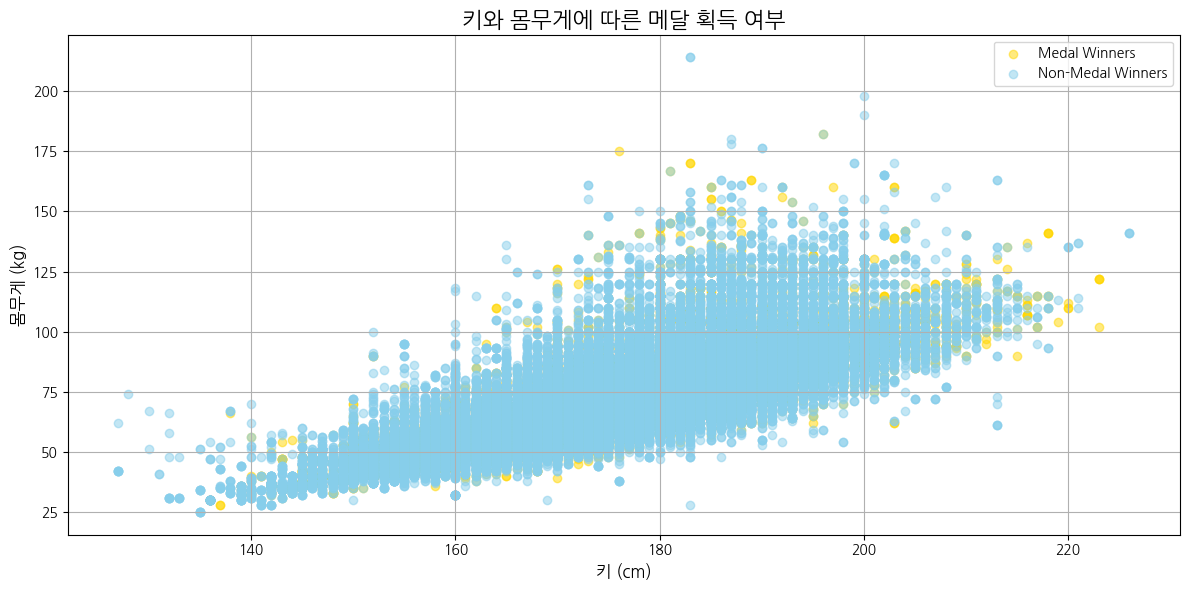

          Height    Weight
Height  1.000000  0.796213
Weight  0.796213  1.000000
             Height    Weight  Medal_Won
Height     1.000000  0.796213   0.087532
Weight     0.796213  1.000000   0.088510
Medal_Won  0.087532  0.088510   1.000000
================================ Human Message =================================

키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.



================================== Ai Message ==================================

키와 몸무게에 따른 메달 획득 여부를 시각적으로 분석한 결과, 금색 점(메달 획득 선수)과 하늘색 점(메달 미획득 선수)이 흩어져 있어, 키와 몸무게만으로는 메달 획득을 명확하게 구분하기 어렵습니다.

키와 몸무게 사이의 상관관계는 0.79로 나타났습니다. 이는 키가 클수록 몸무게가 대체로 많이 나가는 경향이 있음을 의미합니다.

키, 몸무게, 메달 획득 여부 사이의 상관관계를 분석한 결과는 다음과 같습니다.

*   **키**와 **메달 획득 여부**: 0.13
*   **몸무게**와 **메달 획득 여부**: 0.15

이 수치들은 키와 몸무게가 메달 획득에 미치는 영향이 크지 않다는 것을 보여줍니다. 다시 말해, 키가 크거나 몸무게가 많이 나간다고 해서 메달을 더 잘 따는 것은 아니며, 다른 요인들이 메달 획득에 더 중요한 역할을 할 수 있다는 것을 시사합니다.





<Figure size 640x480 with 0 Axes>

In [ ]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "999"})

streaming("키와 체중, 그리고 메달 획득과의 상관관계를 보여주세요. 산점도 그래프로 그려주세요.", config)